# Predicting Patient Readmission with a Hybrid Deep Learning Model

### Project Objective
This notebook develops and optimizes a deep learning model to predict the likelihood of a patient being readmitted to a hospital. The goal is to create a robust, high-performing model by leveraging a hybrid architecture and systematic hyperparameter tuning.

### Methodology
The core of this solution is a hybrid neural network that processes different types of features using specialized layers:
*   **1D Convolutional Neural Network (CNN):** Used to extract spatial patterns from the numerical and one-hot encoded categorical features.
*   **Entity Embeddings:** Used to create dense, meaningful vector representations of high-cardinality categorical features, capturing complex relationships between their categories.
*   **Optuna Hyperparameter Tuning:** We employ the Optuna framework to systematically search for the optimal model configuration, including learning rate, layer sizes, and dropout rates, ensuring a data-driven approach to model design.
*   **Robust Evaluation:** The model is trained using a rigorous process that prevents overfitting by identifying the optimal training duration and is evaluated on a completely unseen test set to provide a reliable measure of its real-world performance.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, concatenate, Reshape, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import optuna

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


In [13]:
# Load the preprocessed data
# The data was preprocessed in the data_preprocessing.ipynb notebook
try:
    data = pd.read_csv('../../dataPreprocessing/medical_data.csv')
except FileNotFoundError:
    data = pd.read_pickle('../../dataPreprocessing/medical_data.pkl')

# These columns are derived from the target variable ('readmitted') and must be removed.
leaky_features = ['mb_readmitted_lt30_ct', 'mb_readmitted_gt30_ct', 'mb_readmitted_no_ct', 'readmitted_ind']
data.drop(columns=[col for col in leaky_features if col in data.columns], inplace=True, errors='ignore')

pd.set_option('display.max_columns', None)
print("Data shape:", data.shape)
print("Data head:")
data.head()

/tmp/ipykernel_689/1422035621.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../dataPreprocessing/medical_data.csv')


Data shape: (78049, 202)
Data head:


,encounter_id,patient_nbr,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source,mb_admission_grp_1_ct,mb_admission_grp_2_ct,mb_discharge_grp_1_ct,mb_discharge_grp_2_ct,mb_admission_type_ct,distinct_diag_count,diagnosis_1,diagnosis_2,diagnosis_3,diag_1_freq,diag_2_freq,diag_3_freq,LTIS_38_ind,LTIS_40_ind,LTIS_36_ind,LTIS_320_ind,LTIS_324_ind,CE_410_ind,CE_430_ind,CE_431_ind,CE_415_ind,CE_428_ind,CMN_155_ind,CMN_162_ind,CMN_191_ind,CMN_197_ind,CMN_199_ind,OF_570_ind,OF_584_ind,OF_585_ind,OF_277_ind,NBD_331_ind,NBD_340_ind,NBD_780_ind,NBD_852_ind,STI_806_ind,STI_861_ind,STI_864_ind,STI_958_ind,OCC_250_ind,OCC_995_ind,OCC_986_ind,OCC_989_ind,diagnosis_combo_frequency,sorted_diag_1,sorted_diag_2,sorted_diag_3,sorted_diag_1_frequency,sorted_diag_2_frequency,sorted_diag_3_frequency,diagnosis_combo_string,is_high_risk_combo,dx_428_ind_max,dx_428_ind_sum,dx_403_ind_max,dx_403_ind_sum,dx_707_ind_max,dx_707_ind_sum,dx_585_ind_max,dx_585_ind_sum,dx_491_ind_max,dx_491_ind_sum,dx_396_ind_max,dx_396_ind_sum,dx_440_ind_max,dx_440_ind_sum,dx_453_ind_max,dx_453_ind_sum,dx_571_ind_max,dx_571_ind_sum,dx_284_ind_max,dx_284_ind_sum,dx_304_ind_max,dx_304_ind_sum,dx_482_ind_max,dx_482_ind_sum,dx_150_ind_max,dx_150_ind_sum,dx_282_ind_max,dx_282_ind_sum,dx_332_ind_max,dx_332_ind_sum,dx_443_ind_max,dx_443_ind_sum,dx_719_ind_max,dx_719_ind_sum,dx_423_ind_max,dx_423_ind_sum,dx_281_ind_max,dx_281_ind_sum,dx_536_ind_max,dx_536_ind_sum,dx_368_ind_max,dx_368_ind_sum,dx_515_ind_max,dx_515_ind_sum,dx_595_ind_max,dx_595_ind_sum,dx_572_ind_max,dx_572_ind_sum,dx_681_ind_max,dx_681_ind_sum,dx_581_ind_max,dx_581_ind_sum,dx_537_ind_max,dx_537_ind_sum,dx_490_ind_max,dx_490_ind_sum,dx_583_ind_max,dx_583_ind_sum,dx_V46_ind_max,dx_V46_ind_sum,dx_519_ind_max,dx_519_ind_sum,dx_300_ind_max,dx_300_ind_sum,dx_567_ind_max,dx_567_ind_sum,dx_E92_ind_max,dx_E92_ind_sum,dx_V49_ind_max,dx_V49_ind_sum,dx_094_ind_max,dx_094_ind_sum,dx_514_ind_max,dx_514_ind_sum,dx_494_ind_max,dx_494_ind_sum,dx_042_ind_max,dx_042_ind_sum,dx_404_ind_max,dx_404_ind_sum,dx_346_ind_max,dx_346_ind_sum,dx_792_ind_max,dx_792_ind_sum,dx_398_ind_max,dx_398_ind_sum,dx_753_ind_max,dx_753_ind_sum,dx_577_ind_max,dx_577_ind_sum,dx_730_ind_max,dx_730_ind_sum,dx_444_ind_max,dx_444_ind_sum,dx_459_ind_max,dx_459_ind_sum,dx_790_ind_max,dx_790_ind_sum,dx_337_ind_max,dx_337_ind_sum,dx_397_ind_max,dx_397_ind_sum,dx_292_ind_max,dx_292_ind_sum,dx_V42_ind_max,dx_V42_ind_sum,dx_289_ind_max,dx_289_ind_sum,alcohol_history_ind,obesity_history_ind,mh_history_ind,encounter_ct,mb_time_in_hospital,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,age_encoded,dummy
0,64410,86047875,Female,2,11,5,13,2,0,1,648,250,V27,6,NaN,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,DIABETES IN PREG-UNSPEC,DIABETES MELLITUS,DELIVER-SINGLE LIVEBORN,285,12794,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,DIABETES MELLITUS,DIABETES IN PREG-UNSPEC,DELIVER-SINGLE LIVEBORN,36015,417,37,(250 648 V27),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,11,5,13,2,0,1,6,1.0,1
1,500364,82442376,Male,2,44,1,16,0,0,0,8,250,403,7,NaN,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,INTEST INFEC E COLI NOS,DIABETES MELLITUS,MAL HY KID W CR KID I-IV,515,12794,2357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,DIABETES MELLITUS,MAL HY KID W CR KID I-IV,INTEST INFEC E COLI NOS,36015,2261,83

## Data Preparation and Preprocessing Strategy

A critical prerequisite for building an effective deep learning model is a robust and well-defined data preprocessing pipeline. Our strategy is designed to handle the mixed data types present in the dataset (numerical, low-cardinality categorical, and high-cardinality categorical) and prepare them for their respective model branches.

The process involves the following key steps:

1.  **Feature and Target Definition**: We first define our target variable, `readmitted_binary`, and isolate the features that will be used for prediction.
2.  **Feature Segregation**: We programmatically separate the features into three distinct groups based on their data type and cardinality (the number of unique values).
3.  **Train-Test Split**: The data is split into training and testing sets *before* any transformations are fitted. This is a crucial step to prevent data leakage and ensure our final evaluation is unbiased.
4.  **Unified Preprocessing Pipeline**: We use Scikit-learn's `ColumnTransformer` to apply the correct transformation to each feature group in a single, unified step:
    *   **Numerical Features**: These are scaled using `StandardScaler` to normalize their range, which helps the model converge more efficiently.
    *   **Low-Cardinality Categorical Features**: These are transformed using `OneHotEncoder`, creating a binary column for each category. This is suitable for features with a small number of unique values.
    -   **High-Cardinality Categorical Features**: These are converted into unique integers using `OrdinalEncoder`. This is not for establishing order, but as a necessary step to prepare these features for the subsequent `Embedding` layers in our neural network, which will learn a meaningful vector representation for each integer.

In [14]:
# The target variable is 'readmitted'. We'll convert this into a binary classification problem:
# 1 if readmitted (value is '<30' or '>30'), 0 otherwise (value is 'NO').
if 'readmitted' in data.columns:
    data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)
    target = 'readmitted_binary'
    
    # Drop original readmitted columns and patient_nbr as it's an identifier
    features = data.drop(columns=[target, 'readmitted', 'patient_nbr'], errors='ignore')
    y = data[target]
    X = features
    
    print("Target variable created.")
    print(y.value_counts())
else:
    print("Target column 'readmitted' not found. Please define the target variable.")
    # As a placeholder:
    X, y = None, None


Target variable created.
readmitted_binary
0    42307
1    35742
Name: count, dtype: int64


In [15]:
if X is not None:
    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # Define a threshold for high cardinality
    CARDINALITY_THRESHOLD = 50
    
    # Separate categorical features into low and high cardinality
    high_cardinality_features = [col for col in categorical_features if X[col].nunique() > CARDINALITY_THRESHOLD]
    low_cardinality_features = [col for col in categorical_features if X[col].nunique() <= CARDINALITY_THRESHOLD]

    print(f"Numerical features: {len(numerical_features)}")
    print(f"Low-cardinality categorical features (to be one-hot encoded): {len(low_cardinality_features)}")
    print(f"High-cardinality categorical features (to be embedded): {len(high_cardinality_features)}")
    print(f" -> High-cardinality features: {high_cardinality_features}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nData split into training and testing sets.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

Numerical features: 176
Low-cardinality categorical features (to be one-hot encoded): 14
High-cardinality categorical features (to be embedded): 10
 -> High-cardinality features: ['diag_1', 'diag_2', 'diag_3', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'sorted_diag_1', 'sorted_diag_2', 'sorted_diag_3', 'diagnosis_combo_string']

Data split into training and testing sets.
X_train shape: (62439, 200)
X_test shape: (15610, 200)


In [16]:
if X is not None:
    # Ensure all categorical columns are strings to avoid mixed-type errors
    for col in low_cardinality_features + high_cardinality_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
            X_test[col] = X_test[col].astype(str)

    # Create transformers for each feature type
    numeric_transformer = StandardScaler()
    low_card_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    high_card_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    # Create a single preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat_low', low_card_transformer, low_cardinality_features),
            ('cat_high', high_card_transformer, high_cardinality_features)
        ],
        remainder='passthrough'
    )

    # Apply the preprocessing
    # The preprocessor is FIT ONLY on the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    # It is then used to TRANSFORM both the training and test data
    X_test_processed = preprocessor.transform(X_test)

    print("Preprocessing complete.")
    print("Processed training data shape:", X_train_processed.shape)
    print("Processed testing data shape:", X_test_processed.shape)

Preprocessing complete.
Processed training data shape: (62439, 268)
Processed testing data shape: (15610, 268)


## Model Architecture and Design

To effectively handle the diverse types of data in our dataset, we have designed a hybrid neural network using the Keras Functional API. This flexible approach allows us to create a multi-branch model where different kinds of features are processed by specialized layers best suited for their nature. The outputs of these branches are then merged to make a final, unified prediction.

The model consists of the following key components:

### 1. Unified Input Layer
A single `Input` layer serves as the entry point for the entire preprocessed feature vector. This vector contains the scaled numerical features, the one-hot encoded low-cardinality features, and the integer-encoded high-cardinality features, all concatenated together.

### 2. Branch 1: CNN for Numerical and Low-Cardinality Features
This branch is designed to process the continuous numerical data and the one-hot encoded categorical data. It uses a 1D Convolutional Neural Network (CNN) to learn spatial hierarchies and patterns within this feature set.
*   **Slicing (`Lambda`):** A `Lambda` layer first slices the main input tensor to isolate only the numerical and one-hot encoded columns.
*   **Reshaping:** The sliced data is reshaped into a 3D tensor, which is the required input format for a `Conv1D` layer.
*   **Convolution (`Conv1D`):** A 1D convolutional layer scans the features to identify local patterns.
*   **Pooling (`MaxPooling1D`):** A max-pooling layer downsamples the output, making the learned patterns more robust.
*   **Flattening:** The pooled feature map is flattened into a 1D vector to be passed to the final classification layers.

### 3. Branch 2: Embeddings for High-Cardinality Features
This branch is dedicated to handling the high-cardinality categorical features, which are not suitable for one-hot encoding.
*   **Slicing (`Lambda`):** For each high-cardinality feature, a `Lambda` layer slices the main input tensor to extract its specific integer-encoded value.
*   **Embedding (`Embedding`):** An `Embedding` layer converts each integer into a dense, low-dimensional vector. This layer learns a meaningful representation for each category, capturing semantic relationships between them in a way that one-hot encoding cannot.
*   **Flattening:** The resulting embedding vectors are flattened to prepare them for merging.

### 4. Merging and Final Classification
*   **Concatenation:** The output vector from the CNN branch is concatenated with the output vectors from all the embedding branches, creating a single, comprehensive feature vector.
*   **Classification Head:** This final, fully-connected part of the network makes the prediction:
    *   A `Dense` layer with a `relu` activation function learns complex, non-linear combinations of the merged features.
    *   A `Dropout` layer is applied for regularization to prevent overfitting.
    *   The final `Dense` output layer consists of a single neuron with a `sigmoid` activation function, which outputs a probability score between 0 and 1 for the binary classification task (readmitted or not).

## Hyperparameter Tuning with Optuna

To find the optimal configuration for our model, we employ a systematic hyperparameter tuning process using the Optuna framework. This process is divided into two key functions:

1.  **`build_model(params)`**: This is a centralized factory function that constructs and compiles our hybrid CNN-Embedding model. It accepts a `params` dictionary, allowing us to dynamically create different versions of the model architecture. This approach ensures our model definition is consistent and easy to maintain.

2.  **`objective(trial)`**: This is the core function that Optuna interacts with. For each trial, it performs the following steps:
    *   **Defines the Search Space**: It asks Optuna to suggest a new set of hyperparameters (e.g., `learning_rate`, `cnn_filters`, `dropout_rate`).
    *   **Builds the Model**: It passes the suggested hyperparameters to our `build_model` function.
    *   **Trains and Validates**: It trains the model on a portion of the training data, using a `validation_split` and an `EarlyStopping` callback. This is crucial for getting an unbiased performance estimate and preventing overfitting within each trial.
    *   **Stores Results**: The training history is saved to the trial's attributes for later analysis.
    *   **Returns the Score**: It returns the best validation loss achieved during the trial, which Optuna then uses to guide its search for the next trial.

The `study.optimize()` command executes this process for a set number of trials, intelligently exploring the hyperparameter space to find the combination that minimizes validation loss.

In [17]:
def build_model(params):    
    # --- 1. Get data shape information from the preprocessor ---
    num_ohe_features = preprocessor.named_transformers_['cat_low'].get_feature_names_out().shape[0]
    ohe_start_idx = len(numerical_features)
    embed_start_idx = ohe_start_idx + num_ohe_features
    
    input_layer = Input(shape=(X_train_processed.shape[1],), name='main_input')

    # --- 2. CNN Branch for numerical and one-hot encoded features ---
    cnn_input_data = Lambda(lambda x: x[:, :embed_start_idx])(input_layer)
    reshaped_cnn_data = Reshape((embed_start_idx, 1))(cnn_input_data)
    conv1d = Conv1D(filters=params['cnn_filters'], kernel_size=3, activation='relu')(reshaped_cnn_data)
    pool1d = MaxPooling1D(pool_size=2)(conv1d)
    flatten_cnn = Flatten()(pool1d)

    # --- 3. Embedding Branch for high-cardinality features ---
    embedding_layers = []
    for i, col_name in enumerate(high_cardinality_features):
        category_input = Lambda(lambda x: x[:, embed_start_idx + i])(input_layer)
        vocab_size = len(preprocessor.named_transformers_['cat_high'].categories_[i])
        embedding = Embedding(input_dim=vocab_size, output_dim=params['embedding_dim'])(category_input)
        flatten_embed = Flatten()(embedding)
        embedding_layers.append(flatten_embed)

    # --- 4. Merge branches and add final classification layers ---
    merged = concatenate([flatten_cnn] + embedding_layers)
    dense1 = Dense(units=params['dense_units'], activation='relu')(merged)
    dropout1 = Dropout(rate=params['dropout_rate'])(dense1)
    output_layer = Dense(1, activation='sigmoid')(dropout1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # --- 5. Compile the model ---
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
def objective(trial):
    # --- 1. Define Hyperparameter Search Space ---
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'cnn_filters': trial.suggest_categorical('cnn_filters', [16, 32, 64]),
        'embedding_dim': trial.suggest_int('embedding_dim', 8, 32),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64, 128]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.3, 0.7)
    }

    # --- 2. Build and compile the model ---
    model = build_model(params)
    
    # --- 3. Train the Model ---
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_processed, y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # --- 4. Evaluate and Return the Metric to Optimize ---
    val_loss = min(history.history['val_loss'])
    # Store the history in the trial to access it later
    trial.set_user_attr("history", history.history) 
    return val_loss

# --- Run the Optuna Study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25) # Run 25 trials to find the best hyperparameters

# --- Print the Best Results ---
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (val_loss): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-28 22:44:22,769] A new study created in memory with name: no-name-3e238ddf-3d23-4aa0-aad4-050a73b651f4
[I 2025-06-28 22:44:43,025] Trial 0 finished with value: 0.4751739501953125 and parameters: {'learning_rate': 0.000240436772368995, 'cnn_filters': 16, 'embedding_dim': 21, 'dense_units': 128, 'dropout_rate': 0.4378345194278686}. Best is trial 0 with value: 0.4751739501953125.
[I 2025-06-28 22:44:59,592] Trial 1 finished with value: 0.47618183493614197 and parameters: {'learning_rate': 0.008568263599296019, 'cnn_filters': 16, 'embedding_dim': 12, 'dense_units': 32, 'dropout_rate': 0.6680174417885951}. Best is trial 0 with value: 0.4751739501953125.
[I 2025-06-28 22:45:12,100] Trial 2 finished with value: 0.4837679862976074 and parameters: {'learning_rate': 0.0032012138797330235, 'cnn_filters': 32, 'embedding_dim': 29, 'dense_units': 32, 'dropout_rate': 0.6349071490230531}. Best is trial 0 with value: 0.4751739501953125.
[I 2025-06-28 22:45:31,906] Trial 3 finished with value

Best trial:
  Value (val_loss): 0.45435258746147156
  Params: 
    learning_rate: 0.00019138226032380012
    cnn_filters: 64
    embedding_dim: 10
    dense_units: 32
    dropout_rate: 0.35560967276555405


## Train and Evaluate the Final Model

After the Optuna study has identified the most promising set of hyperparameters, the final step is to train a definitive model and evaluate its performance on the unseen test set. This process ensures we are using our data and the insights from tuning as effectively as possible.

The workflow is as follows:

1.  **Retrieve Best Hyperparameters**: We extract the `best_params` dictionary from the completed Optuna study. These are the parameters that yielded the lowest validation loss.

2.  **Determine Optimal Training Duration**: To prevent the overfitting, we do not train for a fixed number of epochs. Instead, we inspect the saved `history` from the best trial and find the exact epoch (`optimal_epochs`) at which the validation loss was at its minimum. This is the ideal training duration for our model architecture.

3.  **Build and Train the Final Model**: We call the `build_model` function one last time using the `best_params`. Then, we train this model on the **entire training dataset** for the `optimal_epochs` we just determined. No validation set is used here, as all model-selection decisions have already been made. This step ensures the final model learns from all available training data.

4.  **Final Evaluation**: The fully trained model is evaluated against the completely separate test set. The resulting test accuracy and loss provide the most reliable measure of how the model is expected to perform on new, real-world data.

In [19]:
# --- 1. Get the best hyperparameters from the study ---
best_params = study.best_params

# --- 2. Build the final model with the best hyperparameters ---
final_model = build_model(best_params)
final_model.summary()

# --- 3. Determine the optimal number of epochs from the best trial ---
# Get the history from the best trial
best_trial_history = study.best_trial.user_attrs["history"]
# Find the epoch with the lowest validation loss
optimal_epochs = np.argmin(best_trial_history['val_loss']) + 1
print(f"\nOptimal number of epochs found: {optimal_epochs}")

# --- 4. Train the final model on the full training data for the optimal number of epochs ---
print("Training final model...")
history = final_model.fit(
    X_train_processed, y_train,
    epochs=optimal_epochs, # Use the optimal number of epochs
    batch_size=best_params.get('batch_size', 128), # Use batch size from params if available
    verbose=1
)

# --- 5. Evaluate the final model on the test set ---
loss, accuracy = final_model.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nFinal Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 268)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_561 (Lambda) │ (None, 258)       │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_51          │ (None, 258, 1)    │          0 │ lambda_561[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 256, 64)   │        256 │ reshape_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_562 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_563 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_564 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_565 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_566 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_567 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_568 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_569 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_570 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_571 (Lambda) │ (None)            │          0 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 128, 64)   │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_510       │ (None, 10)        │      6,510 │ lambda_562[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_511       │ (None, 10)        │      6,290 │ lambda_563[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_512       │ (None, 10)        │      6,510 │ lambda_564[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_513       │ (None, 10)        │      6,510 │ lambda_565[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_514       │ (None, 10)        │      6,290 │ lambda_566[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_515       │ (None, 10)        │      6,510 │ lambda_567[0][0]

 Total params: 597,775 (2.28 MB)

 Trainable params: 597,775 (2.28 MB)

 Non-trainable params: 0 (0.00 B)


Optimal number of epochs found: 5
Training final model...
Epoch 1/5


488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7229 - loss: 0.5605
Epoch 2/5
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7649 - loss: 0.5006
Epoch 3/5
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7764 - loss: 0.4818
Epoch 4/5
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7855 - loss: 0.4680
Epoch 5/5
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7946 - loss: 0.4491

Final Test Loss: 0.4581
Final Test Accuracy: 0.7899


488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Final Test AUC Score: 0.8592


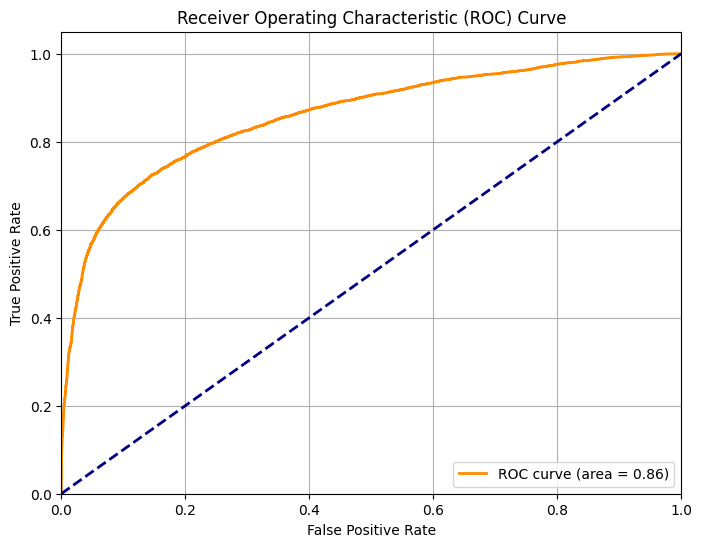

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 6. Calculate and Plot AUC ---

# Get the predicted probabilities for the test set
y_pred_proba = final_model.predict(X_test_processed).ravel()

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Final Test AUC Score: {auc_score:.4f}")

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()